In [9]:
print("STEP 1 완료: corpus 생성")
print("STEP 1 완료: corpus 생성")

STEP 1 완료: corpus 생성
STEP 1 완료: corpus 생성


In [10]:
import pandas as pd
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

from gensim import corpora, models
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt


In [20]:
from gensim.models import LdaMulticore


In [11]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [12]:
from gensim.models import LdaModel, CoherenceModel

def compute_coherence_only(dictionary, corpus, texts, start, limit, step):
    topic_nums = []
    coherence_scores = []

    for num_topics in range(start, limit, step):
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=5,
            iterations=100
        )

        coherence_model = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )

        topic_nums.append(num_topics)
        coherence_scores.append(coherence_model.get_coherence())

    return topic_nums, coherence_scores


In [13]:
df = pd.read_excel(
    "/Users/pinetree/tactile-design-LDA/20251230_scopus_733.xlsx"
)


In [14]:
df["text"] = (
    df["Title"].fillna("") + " " +
    df["Author Keywords"].fillna("") + " " +
    df["Abstract"].fillna("")
)


In [15]:
# 기본 설정
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
tokenizer = TreebankWordTokenizer()

# 사용자 정의 stopwords (원형)
custom_stop = {
    "study","paper","result","results","method","methods","analysis","approach",
    "conclusion","implication","implications","introduction","discussion",
    "based","using","use","used","new","one","two","three","within","across",
    "haptic","touch","tactile","design","process","explore","common","user",
    "work","practice","model","product","system","object","support","effect",
    "research","article","publisher","scopus","elsevier","make","tool","group","show","differ",
    "also","may","might","many","much","however","therefore","thus",
    "present","reflect","task","people","de","et",
    "develop","provide","improve","perform","date","data"
}

# ✅ 핵심: stem 기준 stopwords까지 미리 생성
custom_stop_stem = {stemmer.stem(w) for w in custom_stop}
stop_words_stem = {stemmer.stem(w) for w in stop_words}

# 원형 stopwords
all_stop = stop_words | custom_stop

def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]

    cleaned = []
    for t in tokens:
        t_stem = stemmer.stem(t)

        # ✅ 원형 기준 제거
        if t in all_stop:
            continue

        # ✅ stem 기준 제거 (메타 단어 잔존 문제 해결 핵심)
        if t_stem in custom_stop_stem:
            continue
        if t_stem in stop_words_stem:
            continue

        cleaned.append(t_stem)

    return cleaned


In [16]:
df["tokens"] = df["text"].apply(preprocess_text)

print("문서 수:", len(df))
print("평균 토큰 수:", df["tokens"].apply(len).mean())


문서 수: 733
평균 토큰 수: 112.59481582537516


In [17]:
dictionary = corpora.Dictionary(df["tokens"])
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

print(f"Dictionary size: {len(dictionary)}")


Dictionary size: 1945


In [21]:
lda = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=5,
    iterations=100,
    chunksize=2000,
    eval_every=None,
    workers=4,
    random_state=42
)

In [ ]:
# 사전에 어떤 단어가 남았는지 확인 (빈도수 상위 50개)
token_counts = {}
for doc in corpus:
    for word_id, count in doc:
        token_counts[word_id] = token_counts.get(word_id, 0) + count

# 단어와 빈도수 매칭해서 보기
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
for word_id, count in sorted_tokens[:30]:
    print(f"{dictionary[word_id]}: {count}")

interact: 699
experi: 604
visual: 480
music: 360
digit: 349
materi: 342
social: 334
particip: 319
learn: 315
technolog: 287
interfac: 278
inform: 268
commun: 262
control: 238
sound: 232
sensori: 230
student: 224
art: 222
cultur: 220
percept: 220
children: 215
includ: 208
educ: 208
test: 202
access: 200
limit: 199
gener: 195
space: 194
architectur: 192
devic: 186


=== 토픽 수별 Coherence (c_v) ===
num_topics = 2 | coherence = 0.3352
num_topics = 3 | coherence = 0.3222
num_topics = 4 | coherence = 0.3427
num_topics = 5 | coherence = 0.3459
num_topics = 6 | coherence = 0.3556
num_topics = 7 | coherence = 0.3720
num_topics = 8 | coherence = 0.3693
num_topics = 9 | coherence = 0.3690

최대 Coherence: 0.3720 (토픽 수 = 7)


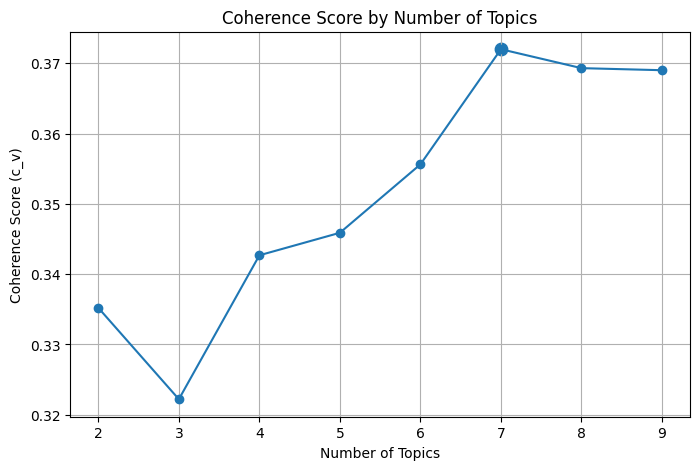

In [22]:
import matplotlib.pyplot as plt

best_k = None
best_coherence = -1

ks = list(range(2, 10))      # 2~9
coherence_scores = []        # ✅ 반드시 for문 밖에서 1번만 초기화

print("=== 토픽 수별 Coherence (c_v) ===")

for k in ks:
    lda_tmp = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        random_state=42,
        passes=5
    )

    coherence_model = CoherenceModel(
        model=lda_tmp,
        texts=df["tokens"],
        dictionary=dictionary,
        coherence="c_v"
    )

    coherence = coherence_model.get_coherence()
    print(f"num_topics = {k} | coherence = {coherence:.4f}")

    coherence_scores.append(coherence)

    if coherence > best_coherence:
        best_coherence = coherence
        best_k = k

print(f"\n최대 Coherence: {best_coherence:.4f} (토픽 수 = {best_k})")

# -----------------------------
# ✅ 그래프 (여기부터 붙이면 됨)
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(ks, coherence_scores, marker="o")
plt.scatter(best_k, best_coherence, s=80)   # 최대값 강조
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score by Number of Topics")
plt.xticks(ks)
plt.grid(True)
plt.show()


In [23]:
num_topics = 7 # ← coherence 결과로 결정

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=20,
    alpha="auto"
)


In [24]:


# Topic 1–7, word(weight) 형태로 출력
for topic_id, topic_words in lda_model.show_topics(
        num_topics=num_topics,
        num_words=10,
        formatted=False
    ):
    formatted_words = [
        f"{word}({weight:.3f})"
        for word, weight in topic_words
    ]
    print(f"Topic {topic_id + 1}: " + ", ".join(formatted_words))


Topic 1: architectur(0.012), materi(0.011), educ(0.010), student(0.009), art(0.009), creativ(0.007), project(0.007), commun(0.007), limit(0.006), experi(0.006)
Topic 2: digit(0.015), interact(0.013), comput(0.012), interfac(0.011), devic(0.010), game(0.010), mobil(0.008), experi(0.007), form(0.007), visual(0.007)
Topic 3: social(0.014), experi(0.010), time(0.007), human(0.007), societi(0.007), particip(0.006), measur(0.006), interact(0.006), vibrotactil(0.006), percept(0.006)
Topic 4: music(0.048), interact(0.027), sound(0.021), instrument(0.020), interfac(0.020), control(0.012), express(0.010), virtual(0.010), experi(0.009), technolog(0.007)
Topic 5: materi(0.016), fashion(0.014), sensori(0.013), experi(0.011), textil(0.010), visual(0.008), textur(0.007), stimul(0.006), social(0.006), exhibit(0.006)
Topic 6: interact(0.020), experi(0.019), visual(0.016), access(0.012), cultur(0.011), emot(0.010), inform(0.010), impair(0.009), museum(0.009), technolog(0.009)
Topic 7: children(0.015), p

In [25]:
rows = []
topics = lda_model.show_topics(
    num_topics=num_topics,
    num_words=10,
    formatted=False
)

for topic_id, words in topics:
    for word, weight in words:
        rows.append({
            "topic": topic_id,
            "word": word,
            "weight": weight
        })

topic_df = pd.DataFrame(rows)
topic_df


,topic,word,weight
0,0,architectur,0.012142
1,0,materi,0.010900
2,0,educ,0.009723
3,0,student,0.009426
4,0,art,0.008954
...,...,...,...
65,6,behavior,0.007115
66,6,treatment,0.006956
67,6,visual,0.006857
68,6,interact,0.006557


중복포함단어수

In [26]:
all_tokens = [token for doc in df["tokens"] for token in doc]
total_token_count = len(all_tokens)

print(f"중복 포함 단어 수 (Total tokens): {total_token_count}")


중복 포함 단어 수 (Total tokens): 82532


고유단어수

In [27]:
unique_token_count = len(set(all_tokens))

print(f"고유 단어 수 (Unique tokens): {unique_token_count}")


고유 단어 수 (Unique tokens): 9682


문서 평균 단어 수 (논문에 자주 쓰임)

In [28]:
avg_tokens_per_doc = df["tokens"].apply(len).mean()

print(f"문서당 평균 단어 수: {avg_tokens_per_doc:.2f}")


문서당 평균 단어 수: 112.59


(선택) Dictionary 기준 어휘 크기

In [29]:
print(f"LDA Dictionary 단어 수: {len(dictionary)}")


LDA Dictionary 단어 수: 1945


perplexity 최적값

In [30]:


def compute_perplexity_only(dictionary, corpus, start=2, limit=15, step=1):
    topic_nums = []
    perplexity_scores = []

    for k in range(start, limit + 1, step):
        lda = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=20,
            alpha="auto"
        )

        # gensim은 log perplexity 반환
        log_perplexity = lda.log_perplexity(corpus)
        perplexity = np.exp(-log_perplexity)

        topic_nums.append(k)
        perplexity_scores.append(perplexity)

        print(f"k={k:2d} | Perplexity={perplexity:.2f}")

    return topic_nums, perplexity_scores


In [31]:
topic_nums, perplexity_scores = compute_perplexity_only(
    dictionary=dictionary,
    corpus=corpus,
    start=2,
    limit=7,
    step=1
)


k= 2 | Perplexity=1156.91
k= 3 | Perplexity=1088.70
k= 4 | Perplexity=1085.49
k= 5 | Perplexity=1101.94
k= 6 | Perplexity=1121.81
k= 7 | Perplexity=1115.86


In [32]:
optimal_k = topic_nums[np.argmin(perplexity_scores)]
min_perplexity = min(perplexity_scores)

print(f"최소 Perplexity: {min_perplexity:.2f} (토픽 수 = {optimal_k})")


최소 Perplexity: 1085.49 (토픽 수 = 4)


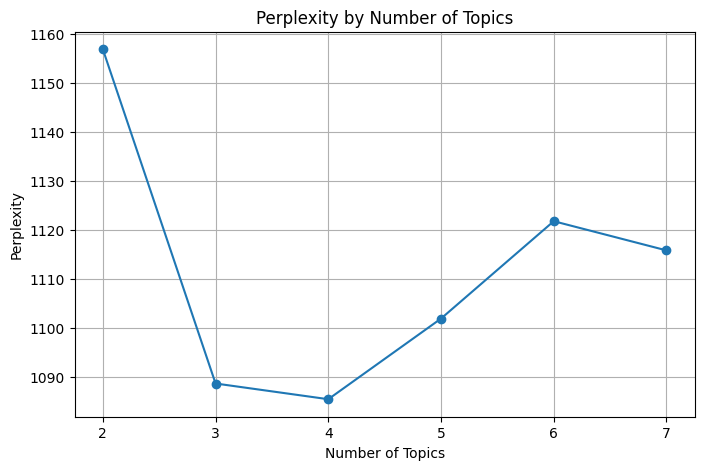

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexity_scores, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity by Number of Topics")
plt.xticks(topic_nums)
plt.grid(True)
plt.show()


In [34]:

perplexity_df = pd.DataFrame({
    "num_topics": topic_nums,
    "perplexity": perplexity_scores
})

perplexity_df.to_csv(
    "데이터/lda_perplexity.csv",
    index=False,
    encoding="utf-8-sig"
)


토픽 내 단어 수 결정

In [35]:


topn = 15

rows = []
for topic_id in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_id, topn=topn)
    for rank, (word, prob) in enumerate(topic_terms, start=1):
        rows.append({
            "topic": f"Topic {topic_id+1}",
            "rank": rank,
            "term": word,
            "probability": prob
        })

topic_terms_df_round = pd.DataFrame(rows).sort_values(["topic","rank"]).reset_index(drop=True)
topic_terms_df_round["cum_prob"] = topic_terms_df_round.groupby("topic")["probability"].cumsum()



In [36]:
topic_terms_df_round.groupby("topic")["cum_prob"].max().sort_values()


topic
Topic 3    0.102009
Topic 1    0.110711
Topic 7    0.123281
Topic 5    0.124012
Topic 2    0.128857
Topic 6    0.156151
Topic 4    0.218969
Name: cum_prob, dtype: float32

In [37]:
topic_terms_df_round["cum_prob"] = (
    topic_terms_df_round
    .groupby("topic")["probability"]
    .cumsum()
)

topic_terms_df_round


,topic,rank,term,probability,cum_prob
0,Topic 1,1,architectur,0.012142,0.012142
1,Topic 1,2,materi,0.010900,0.023042
2,Topic 1,3,educ,0.009723,0.032765
3,Topic 1,4,student,0.009426,0.042190
4,Topic 1,5,art,0.008954,0.051145
...,...,...,...,...,...
100,Topic 7,11,speech,0.006336,0.099414
101,Topic 7,12,evalu,0.006201,0.105614
102,Topic 7,13,feedback,0.006006,0.111620
103,Topic 7,14,adult,0.005840,0.117460


시각화

In [38]:

# num_topics = 4   # coherence로 결정한 값

# lda_model = models.LdaModel(
#     corpus=corpus,
#     id2word=dictionary,
#     num_topics=num_topics,
#     random_state=42,
#     passes=20,
#     alpha="auto"
# )


In [39]:

print(lda_model)


LdaModel<num_terms=1945, num_topics=7, decay=0.5, chunksize=2000>


In [40]:
pip install "pandas==1.5.3"


Note: you may need to restart the kernel to use updated packages.


In [41]:
import pandas as pd, pyLDAvis
print("pandas:", pd.__version__)
print("pyLDAvis:", pyLDAvis.__version__)


pandas: 1.5.3
pyLDAvis: 3.4.0


In [42]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display

vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

pyLDAvis.enable_notebook()
display(vis_data)



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.053495  0.137796       1        1  19.662916
1     -0.090552  0.000231       2        1  11.613419
2      0.083833 -0.052110       3        1  11.222749
3     -0.149616 -0.129971       4        1  10.464031
4      0.058254  0.081416       5        1  11.100313
5     -0.005042  0.040677       6        1  16.000962
6      0.156619 -0.078040       7        1  19.935609, topic_info=           Term        Freq       Total Category  logprob  loglift
861       music  337.000000  337.000000  Default  30.0000  30.0000
25     interact  674.000000  674.000000  Default  29.0000  29.0000
229       sound  220.000000  220.000000  Default  28.0000  28.0000
92     interfac  265.000000  265.000000  Default  27.0000  27.0000
256  instrument  165.000000  165.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
127      visual   91.077455  468.105519   Topic7  -4.9824  -0.0243
594  experiment   58.566789  127.413042   Topic7  -5.4240   0.8354
700     suggest   58.647783  130.221604   Topic7  -5.4226   0.8150
25     interact   87.080314  674.713865   Topic7  -5.0273  -0.4348
152        find   59.723033  171.997507   Topic7  -5.4044   0.5549

[491 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
49        1  0.045565  access
49        2  0.197448  access
49        3  0.005063  access
49        4  0.030377  access
49        5  0.030377  access
...     ...       ...     ...
1497      7  0.622321    word
1446      3  0.837614   write
1446      4  0.143007   write
1250      2  0.117308    york
1250      3  0.821156    york

[1533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7])

🔹 (A) 토픽별 상위 단어 Bar Chart

“각 토픽을 구성하는 핵심 단어는 무엇인가”

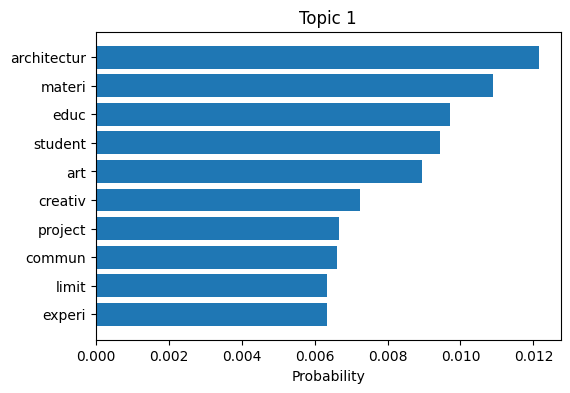

In [43]:
import matplotlib.pyplot as plt

def plot_top_words(lda_model, dictionary, topic_id, topn=10):
    words_probs = lda_model.show_topic(topic_id, topn=topn)
    words, probs = zip(*words_probs)

    plt.figure(figsize=(6,4))
    plt.barh(words, probs)
    plt.gca().invert_yaxis()
    plt.title(f"Topic {topic_id+1}")
    plt.xlabel("Probability")
    plt.show()

# 예시
plot_top_words(lda_model, dictionary, topic_id=0)


🔹 (B) 모든 토픽 한 번에 (Subplot)

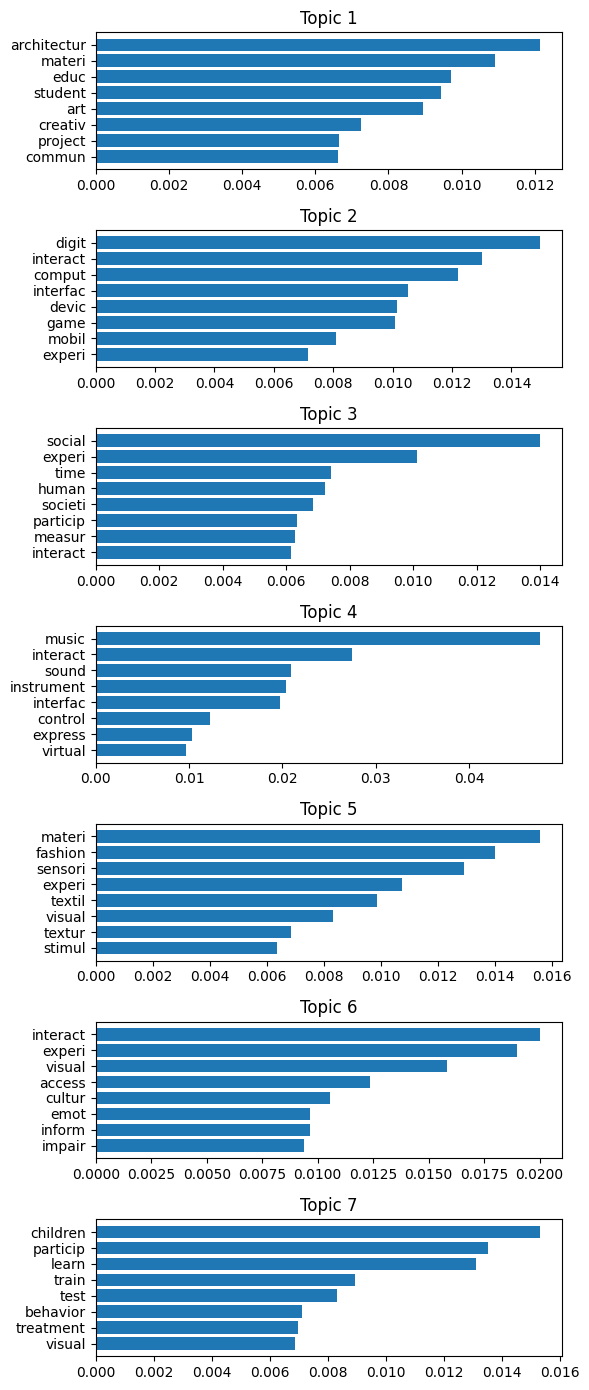

In [44]:
fig, axes = plt.subplots(lda_model.num_topics, 1, figsize=(6, 2*lda_model.num_topics))

for i, ax in enumerate(axes):
    words_probs = lda_model.show_topic(i, topn=8)
    words, probs = zip(*words_probs)
    ax.barh(words, probs)
    ax.set_title(f"Topic {i+1}")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [45]:
doc_topics = [
    [prob for _, prob in lda_model.get_document_topics(bow, minimum_probability=0)]
    for bow in corpus
]

doc_topic_df = pd.DataFrame(doc_topics)

doc_topic_df.head()


,0,1,2,3,4,5,6
0,0.001305,0.000930,0.993687,0.000830,0.000888,0.001054,0.001306
1,0.000626,0.076111,0.000449,0.000397,0.000426,0.921365,0.000626
2,0.755368,0.000494,0.061503,0.000440,0.000471,0.181031,0.000693
3,0.000900,0.000642,0.995647,0.000572,0.000612,0.000727,0.000901
4,0.000951,0.000678,0.347814,0.228013,0.216817,0.000768,0.204959


2️⃣ 문서–토픽 관계 시각화 (해석용으로 매우 중요)
🔹 (C) 문서별 주요 토픽 분포 (Stacked Bar)

“문서들은 어떤 토픽 조합으로 구성되는가”

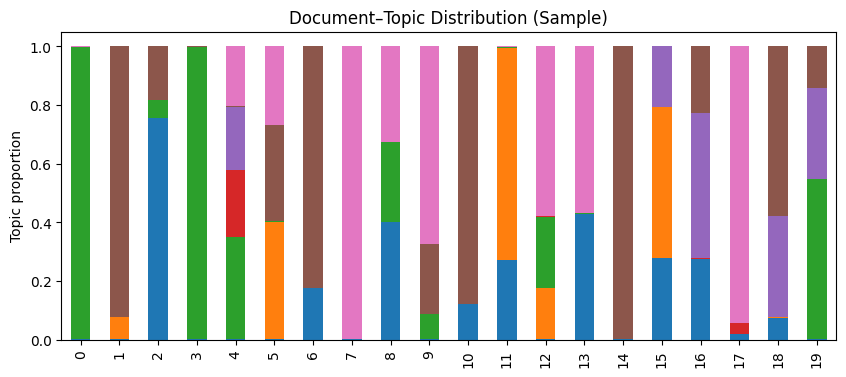

In [46]:
doc_topic_df.iloc[:20].plot(
    kind="bar",
    stacked=True,
    figsize=(10,4),
    legend=False
)
plt.ylabel("Topic proportion")
plt.title("Document–Topic Distribution (Sample)")
plt.show()


🔹 (D) 각 토픽이 차지하는 평균 비중

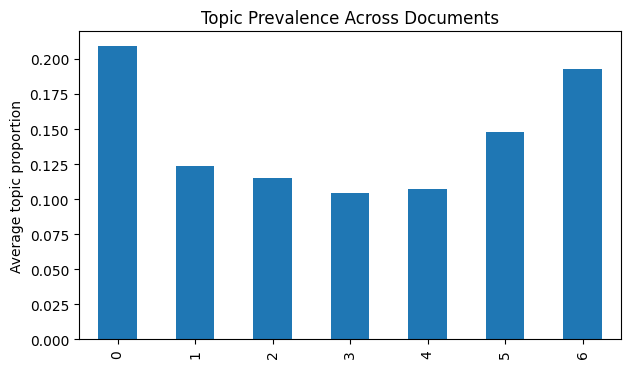

In [47]:
topic_prevalence = doc_topic_df.mean()

topic_prevalence.plot(
    kind="bar",
    figsize=(7,4)
)
plt.ylabel("Average topic proportion")
plt.title("Topic Prevalence Across Documents")
plt.show()


3️⃣ 토픽 간 유사도 / 구조 시각화 (고급)
🔹 (E) 토픽 간 코사인 유사도 Heatmap

“토픽들이 서로 얼마나 겹치는가”

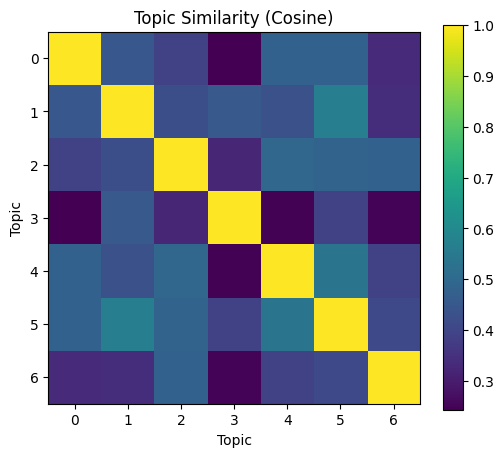

In [48]:
from sklearn.metrics.pairwise import cosine_similarity

topic_word_matrix = lda_model.get_topics()
similarity = cosine_similarity(topic_word_matrix)

plt.figure(figsize=(6,5))
plt.imshow(similarity, cmap="viridis")
plt.colorbar()
plt.title("Topic Similarity (Cosine)")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


🔹 (F) PCA / t-SNE로 토픽 위치 시각화

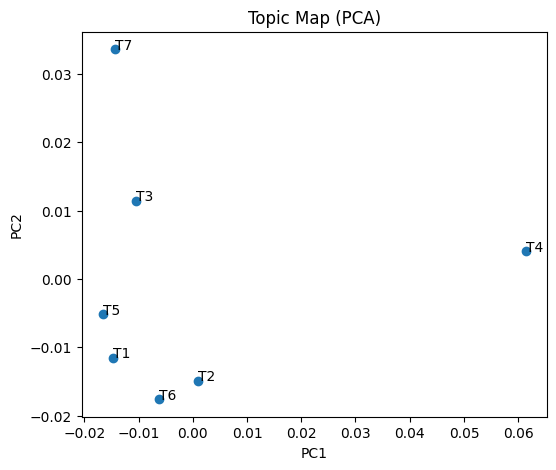

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coords = pca.fit_transform(topic_word_matrix)

plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1])

for i in range(len(coords)):
    plt.text(coords[i,0], coords[i,1], f"T{i+1}")

plt.title("Topic Map (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


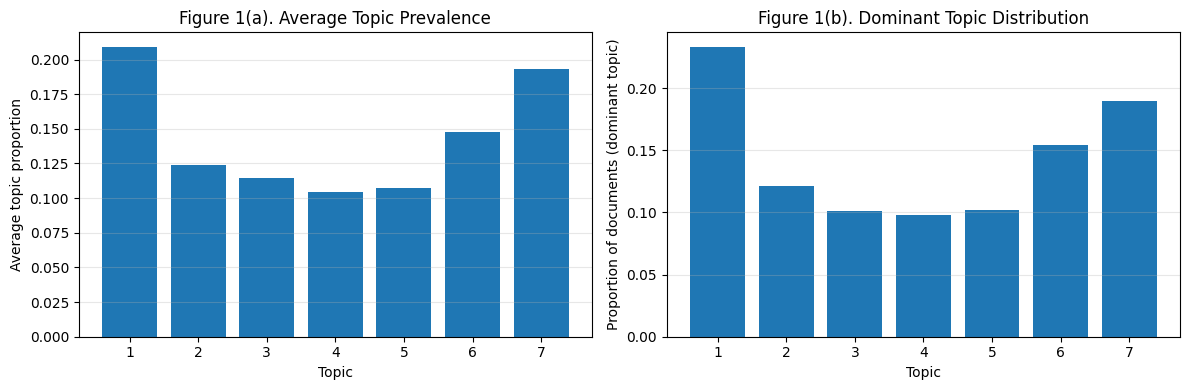

,topic,avg_prevalence,dominant_doc_count,dominant_doc_ratio
0,Topic 1,0.209156,171,0.233288
1,Topic 2,0.123537,89,0.121419
2,Topic 3,0.114843,74,0.100955
3,Topic 4,0.104381,72,0.098226
4,Topic 5,0.107339,75,0.102319
5,Topic 6,0.147855,113,0.154161
6,Topic 7,0.192889,139,0.189632


In [50]:

# import matplotlib.pyplot as plt

# =========================================================
# Figure 1(a) Average Topic Prevalence
#  + Figure 1(b) Dominant Topic Distribution
# =========================================================

K = lda_model.num_topics

# 1) 문서-토픽 분포 행렬 만들기 (N_docs x K)
doc_topic = np.zeros((len(corpus), K), dtype=float)
for i, bow in enumerate(corpus):
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        doc_topic[i, tid] = prob

doc_topic_df = pd.DataFrame(
    doc_topic,
    columns=[f"Topic {i+1}" for i in range(K)]
)

# 2) (a) 평균 토픽 비중
avg_prevalence = doc_topic_df.mean(axis=0).values  # 길이 K

# 3) (b) 지배적 토픽(각 문서에서 가장 큰 토픽) 빈도/비율
dominant_topic_idx = doc_topic_df.values.argmax(axis=1)  # 0..K-1
dominant_counts = pd.Series(dominant_topic_idx).value_counts().sort_index()
dominant_counts = dominant_counts.reindex(range(K), fill_value=0)

dominant_ratio = dominant_counts / len(corpus)

# 4) Figure 1(a)+(b) 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ---- (a) Average Topic Prevalence ----
axes[0].bar(range(1, K+1), avg_prevalence)
axes[0].set_title("Figure 1(a). Average Topic Prevalence")
axes[0].set_xlabel("Topic")
axes[0].set_ylabel("Average topic proportion")
axes[0].set_xticks(range(1, K+1))
axes[0].grid(True, axis="y", alpha=0.3)

# ---- (b) Dominant Topic Distribution ----
axes[1].bar(range(1, K+1), dominant_ratio.values)
axes[1].set_title("Figure 1(b). Dominant Topic Distribution")
axes[1].set_xlabel("Topic")
axes[1].set_ylabel("Proportion of documents (dominant topic)")
axes[1].set_xticks(range(1, K+1))
axes[1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# 5) (선택) 표로 저장 (논문 표/부록/검증용)
out_df = pd.DataFrame({
    "topic": [f"Topic {i+1}" for i in range(K)],
    "avg_prevalence": avg_prevalence,
    "dominant_doc_count": dominant_counts.values,
    "dominant_doc_ratio": dominant_ratio.values
})

out_df


A) 토픽별 비중 변화: 연도별 Topic Prevalence Over Time
1) 연도 컬럼 자동 탐색 + 정리

Scopus 엑셀은 보통 Year, Publication Year, Year Published 같은 이름이 많아서 자동으로 찾아 씁니다.

In [51]:

# 1) 연도 컬럼 찾기 (가능한 후보들)
year_candidates = [
    "Year", "Publication Year", "Year Published", "PubYear", "PY", "출판연도", "연도"
]

year_col = None
for c in year_candidates:
    if c in df.columns:
        year_col = c
        break

if year_col is None:
    raise ValueError(f"연도 컬럼을 못 찾았어요. df.columns에서 연도 컬럼명을 확인해 주세요.\n{list(df.columns)}")

print("연도 컬럼:", year_col)

# 2) 연도 정수화
years = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")


연도 컬럼: Year


In [52]:
[c for c in df.columns if "year" in c.lower() or "date" in c.lower()]


['Year']

In [53]:

# ✅ 문서(행) 수와 동일한 길이로 years 생성
years = pd.to_numeric(df[year_col], errors="coerce")

print("문서 수:", len(df), " / years 길이:", len(years))
years.head()


문서 수: 733  / years 길이: 733


0    2026
1    2025
2    2025
3    2025
4    2025
Name: Year, dtype: int64

In [54]:
years.value_counts().sort_index()

1974     2
1976     2
1980     2
1981     2
1982     2
1983     1
1984     4
1985     2
1986     3
1987     2
1989     4
1990     5
1991     3
1992     2
1993     1
1994     2
1995     2
1996     2
1997    11
1998     4
1999     2
2000     3
2001     5
2002     3
2003     4
2004     3
2005    14
2006    10
2007    11
2008    12
2009    17
2010    19
2011    19
2012    21
2013    24
2014    31
2015    33
2016    20
2017    49
2018    33
2019    33
2020    41
2021    53
2022    40
2023    49
2024    56
2025    69
2026     1
Name: Year, dtype: int64

2) 연도별 평균 토픽 비중 계산 + 라인 플롯

In [55]:
print("doc_topic_df rows:", len(doc_topic_df))
print("years len:", len(years))


doc_topic_df rows: 733
years len: 733


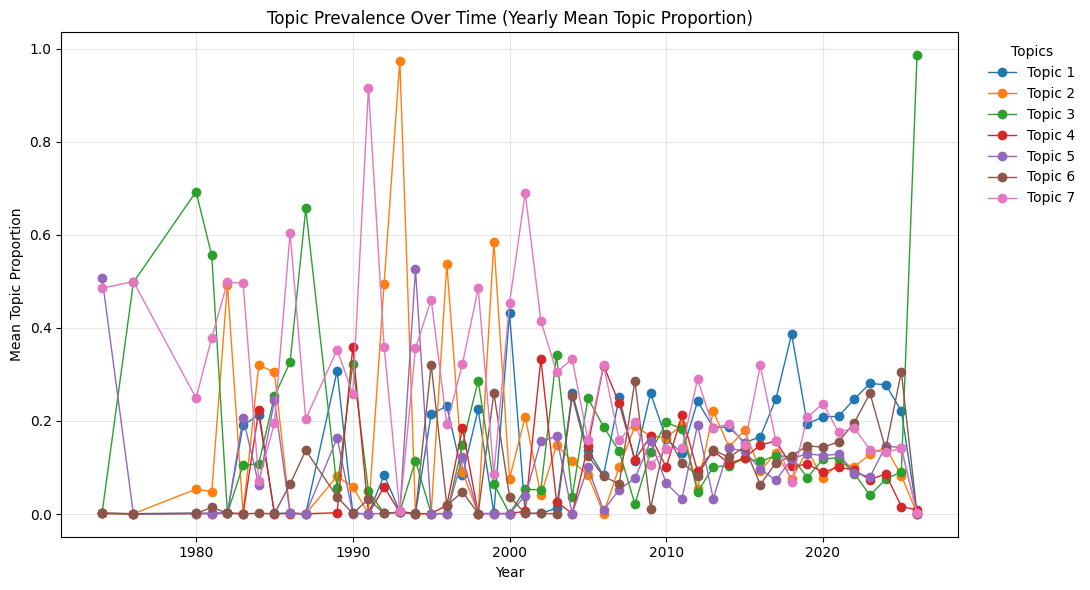

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
year,,,,,,,
1974,0.001763,0.001257,0.001266,0.001120,0.508011,0.001423,0.485159
1976,0.000722,0.000515,0.497753,0.000459,0.000492,0.000583,0.499477
1980,0.001529,0.053592,0.692442,0.000971,0.001040,0.001234,0.249192
1981,0.001475,0.048073,0.555516,0.000937,0.001004,0.014097,0.378898
1982,0.002391,0.492877,0.001717,0.001519,0.001627,0.001930,0.497940


In [56]:
# =========================================================
# 연도별 토픽 비중 (Topic Prevalence Over Time)
# - 컬러–토픽 대응 명확
# - 연도별 평균 토픽 비중 확인
# =========================================================

# 1) doc_topic_df에 문서별 연도 결합
dt = doc_topic_df.copy()

# df의 Year 컬럼 사용 (문서 수와 동일해야 함)
dt["year"] = pd.to_numeric(df["Year"], errors="coerce")

# 2) 결측 연도 제거 + 정수형 변환
dt = dt.dropna(subset=["year"])
dt["year"] = dt["year"].astype(int)

# 3) 연도별 평균 토픽 비중 계산
topic_cols = doc_topic_df.columns.tolist()

yearly = (
    dt.groupby("year")[topic_cols]
      .mean()
      .sort_index()
)

# 4) 시각화
plt.figure(figsize=(11, 6))

for col in yearly.columns:
    plt.plot(
        yearly.index,
        yearly[col],
        marker="o",
        linewidth=1,
        label=col   # 컬러–토픽 대응
    )

plt.title("Topic Prevalence Over Time (Yearly Mean Topic Proportion)")
plt.xlabel("Year")
plt.ylabel("Mean Topic Proportion")
plt.grid(True, alpha=0.3)

# 범례 (논문용 정석 위치)
plt.legend(
    title="Topics",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.show()

# 5) 연도별 정확한 수치 확인
yearly.head()


In [57]:
# 5) 정확한 데이터값 확인
yearly.head()

yearly.to_excel(
    "yearly_topic_prevalence.xlsx",
    sheet_name="yearly_topic_prevalence"
)


📌 논문에선 보통 상위 N개 토픽만 보여주는 게 더 깔끔합니다. (예: 평균 비중 상위 4개)

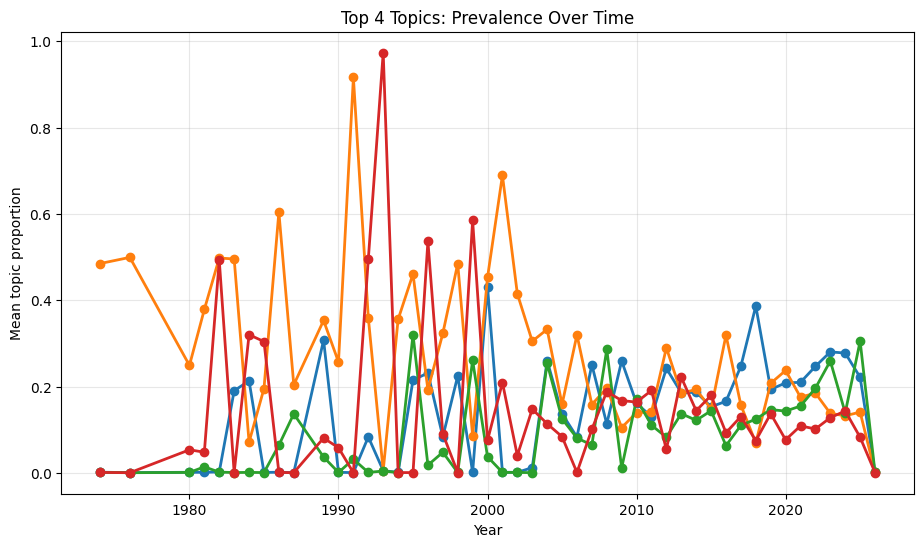

['Topic 1', 'Topic 7', 'Topic 6', 'Topic 2']

In [58]:

topN = 4
top_topics = doc_topic_df.mean().sort_values(ascending=False).head(topN).index

plt.figure(figsize=(11, 6))
for col in top_topics:
    plt.plot(yearly.index, yearly[col], marker="o", linewidth=2)

plt.title(f"Top {topN} Topics: Prevalence Over Time")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.grid(True, alpha=0.3)
plt.show()

top_topics.tolist()


B) “주기적 상승/하락 패턴” 정량화

연도 데이터는 보통 계절성(12개월)은 없지만, “주기성(몇 년 단위 등)” 주장은 가능해요. 논문/리뷰 대응에 가장 무난한 조합은:

이동평균(스무딩)으로 추세 vs 변동 분리

ACF(자기상관)으로 주기 후보(몇 년 단위) 제시

1) 이동평균(rolling mean)

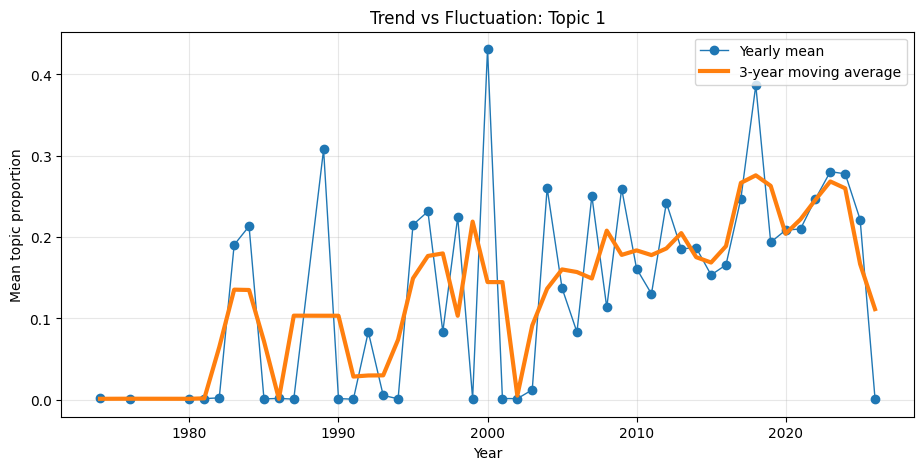

In [59]:

topic_to_check = top_topics[0]  # 가장 큰 토픽 하나부터 체크 (원하면 바꿔도 됨)

series = yearly[topic_to_check].copy()
roll = series.rolling(window=3, center=True, min_periods=1).mean()  # 3년 이동평균

plt.figure(figsize=(11, 5))
plt.plot(series.index, series.values, marker="o", linewidth=1, label="Yearly mean")
plt.plot(roll.index, roll.values, linewidth=3, label="3-year moving average")
plt.title(f"Trend vs Fluctuation: {topic_to_check}")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [60]:
category_map = {
    "Material- and Spatially Grounded Design Practices": ["Topic 1","Topic 5", "Topic 6"],
    "Sensory Social Interaction and Learning & Development": ["Topic 3", "Topic 7"],
    "Digital and Media-Based Interaction": ["Topic 2","Topic 4"]
}


In [61]:

category_yearly = pd.DataFrame(index=yearly.index)

for cat, topics in category_map.items():
    category_yearly[cat] = yearly[topics].sum(axis=1)
    # 평균을 쓰고 싶으면 .mean(axis=1)


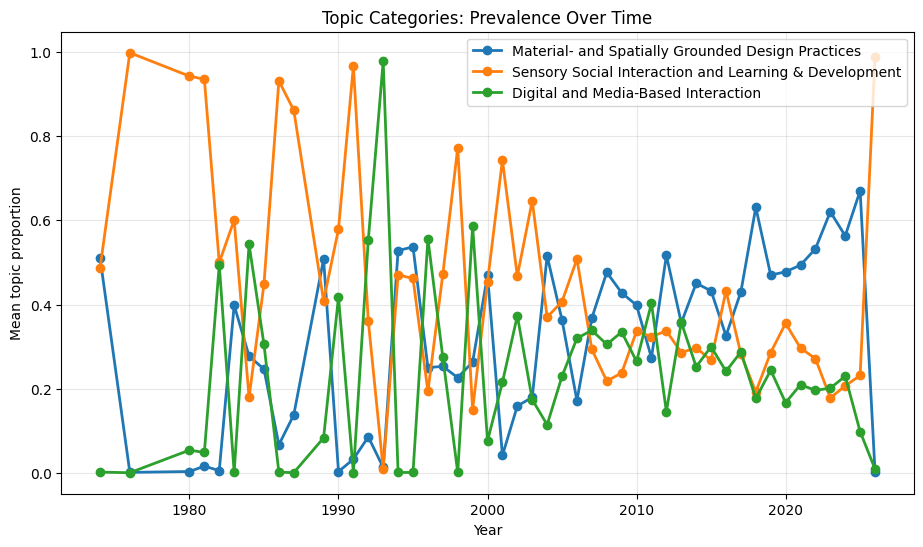

In [62]:
plt.figure(figsize=(11, 6))

for col in category_yearly.columns:
    plt.plot(
        category_yearly.index,
        category_yearly[col],
        marker="o",
        linewidth=2,
        label=col
    )

plt.title("Topic Categories: Prevalence Over Time")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


2) ACF(자기상관) — “몇 년 주기” 힌트
📌 해석 포인트(논문용):

Lag 2~5에서 양의 상관이 반복되면 “몇 년 단위의 반복적 변동 가능성”을 탐색적으로 제시할 수 있어요.

단, 표본연도 수가 적으면(예: 10년 이하) 강한 주장 금지하고 “exploratory”로 쓰는 게 안전합니다.

/var/folders/dw/s7gyvbt14193__4lgngl_yr80000gn/T/ipykernel_849/3901874424.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)
/var/folders/dw/s7gyvbt14193__4lgngl_yr80000gn/T/ipykernel_849/3901874424.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)


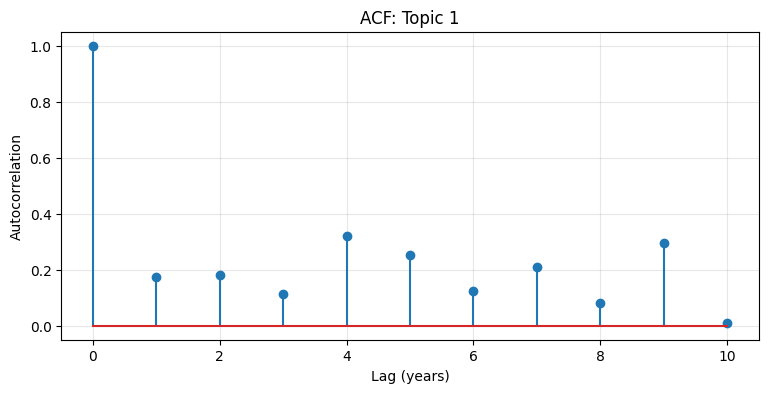

In [63]:

def plot_acf_manual(x, max_lag=10, title="ACF"):
    x = np.asarray(x, dtype=float)
    x = x - np.nanmean(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < 3:
        raise ValueError("ACF를 계산하기엔 연도 데이터 포인트가 너무 적어요.")

    acf_vals = []
    for lag in range(max_lag + 1):
        if lag == 0:
            acf_vals.append(1.0)
        else:
            acf_vals.append(np.corrcoef(x[:-lag], x[lag:])[0, 1])

    plt.figure(figsize=(9, 4))
    plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)
    plt.title(title)
    plt.xlabel("Lag (years)")
    plt.ylabel("Autocorrelation")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_acf_manual(series.values, max_lag=10, title=f"ACF: {topic_to_check}")


C) 토픽 간 유사도 매트릭스 (Topic Similarity Matrix)

가장 보편적이고 리뷰어 설득에 바로 먹힙니다.

1) 토픽-단어 분포 행렬 기반 코사인 유사도

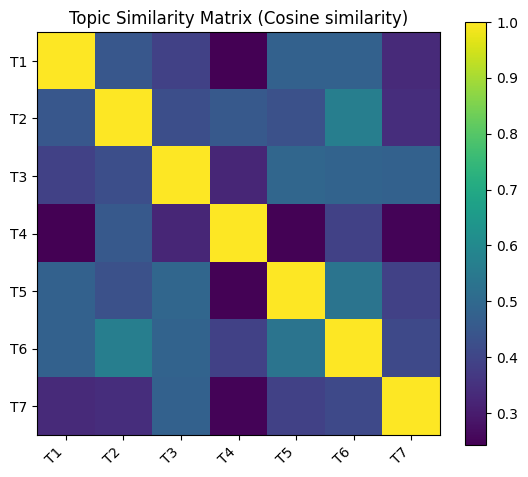

,T1,T2,T3,T4,T5,T6,T7
T1,1.000,0.449,0.390,0.242,0.476,0.477,0.331
T2,0.449,1.000,0.424,0.454,0.431,0.565,0.341
T3,0.390,0.424,1.000,0.323,0.493,0.485,0.476
T4,0.242,0.454,0.323,1.000,0.247,0.389,0.250
T5,0.476,0.431,0.493,0.247,1.000,0.533,0.390


In [64]:


topic_word = lda_model.get_topics()   # (K x V) 토픽-단어 확률행렬
sim = cosine_similarity(topic_word)  # (K x K)

plt.figure(figsize=(6.5, 5.5))
plt.imshow(sim)
plt.colorbar()
plt.title("Topic Similarity Matrix (Cosine similarity)")
plt.xticks(range(K), [f"T{i+1}" for i in range(K)], rotation=45, ha="right")
plt.yticks(range(K), [f"T{i+1}" for i in range(K)])
plt.grid(False)
plt.show()

sim_df = pd.DataFrame(sim, index=[f"T{i+1}" for i in range(K)], columns=[f"T{i+1}" for i in range(K)])
sim_df.round(3).head()


1️⃣ 토픽별 연도 변화 기울기(slope) 계산

단순선형회귀: topic_prevalence=β0​+β1​⋅year

In [65]:

years = yearly.index.values.astype(float)

slope_rows = []

for topic in yearly.columns:
    y = yearly[topic].values.astype(float)

    # 결측 제거
    mask = ~np.isnan(y)
    x = years[mask]
    y = y[mask]

    if len(x) < 3:
        slope = np.nan
        r2 = np.nan
    else:
        # 1차 회귀
        coef = np.polyfit(x, y, 1)
        slope = coef[0]

        # R^2 계산 (설명력 보조 지표)
        y_hat = np.polyval(coef, x)
        ss_res = np.sum((y - y_hat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    slope_rows.append({
        "topic": topic,
        "slope": slope,
        "r2": r2
    })

slope_df = pd.DataFrame(slope_rows)
slope_df


,topic,slope,r2
0,Topic 1,0.004304,0.273852
1,Topic 2,-0.001188,0.008469
2,Topic 3,-0.002032,0.021179
3,Topic 4,0.001943,0.085852
4,Topic 5,-0.000117,0.000225
5,Topic 6,0.003503,0.290517
6,Topic 7,-0.006413,0.261780


In [66]:

slope_df_sorted = slope_df.sort_values("slope", ascending=False)
slope_df_sorted


,topic,slope,r2
0,Topic 1,0.004304,0.273852
5,Topic 6,0.003503,0.290517
3,Topic 4,0.001943,0.085852
4,Topic 5,-0.000117,0.000225
1,Topic 2,-0.001188,0.008469
2,Topic 3,-0.002032,0.021179
6,Topic 7,-0.006413,0.261780


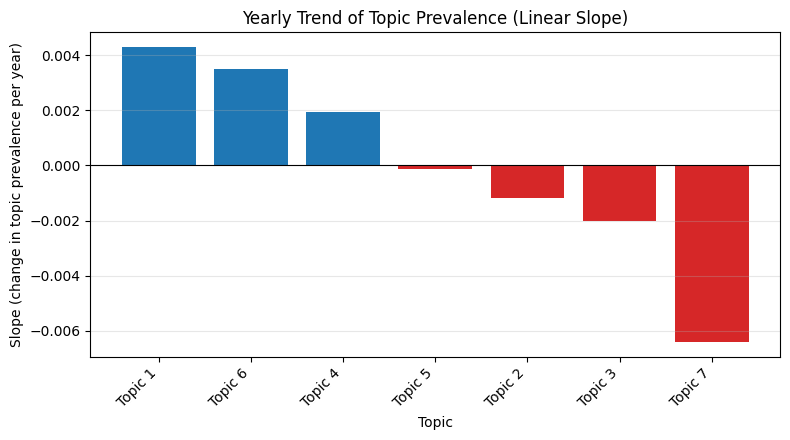

In [67]:

plt.figure(figsize=(8, 4.5))

colors = ["#1f77b4" if s > 0 else "#d62728" for s in slope_df_sorted["slope"]]

plt.bar(
    slope_df_sorted["topic"],
    slope_df_sorted["slope"],
    color=colors
)

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Slope (change in topic prevalence per year)")
plt.xlabel("Topic")
plt.title("Yearly Trend of Topic Prevalence (Linear Slope)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [68]:

slope_df_sorted["slope_z"] = (
    (slope_df_sorted["slope"] - slope_df_sorted["slope"].mean())
    / slope_df_sorted["slope"].std()
)

slope_df_sorted


,topic,slope,r2,slope_z
0,Topic 1,0.004304,0.273852,1.169459
5,Topic 6,0.003503,0.290517,0.951982
3,Topic 4,0.001943,0.085852,0.528020
4,Topic 5,-0.000117,0.000225,-0.031688
1,Topic 2,-0.001188,0.008469,-0.322855
2,Topic 3,-0.002032,0.021179,-0.552176
6,Topic 7,-0.006413,0.261780,-1.742743


In [69]:
!pip install statsmodels

In [70]:

import statsmodels.api as sm

years = yearly.index.values.astype(float)

rows = []

for topic in yearly.columns:
    y = yearly[topic].values.astype(float)

    # 결측 제거
    mask = ~np.isnan(y)
    x = years[mask]
    y = y[mask]

    if len(x) < 3:
        rows.append({
            "topic": topic,
            "slope": np.nan,
            "p_value": np.nan,
            "r2": np.nan,
            "n_years": len(x)
        })
        continue

    X = sm.add_constant(x)  # [1, year]
    model = sm.OLS(y, X).fit()

    rows.append({
        "topic": topic,
        "slope": model.params[1],          # β1
        "p_value": model.pvalues[1],       # p-value for slope
        "r2": model.rsquared,              # R²
        "n_years": int(model.nobs)
    })

reg_df = pd.DataFrame(rows)
reg_df


,topic,slope,p_value,r2,n_years
0,Topic 1,0.004304,0.000135,0.273852,48
1,Topic 2,-0.001188,0.533876,0.008469,48
2,Topic 3,-0.002032,0.323664,0.021179,48
3,Topic 4,0.001943,0.043271,0.085852,48
4,Topic 5,-0.000117,0.919471,0.000225,48
5,Topic 6,0.003503,0.000077,0.290517,48
6,Topic 7,-0.006413,0.000202,0.261780,48


In [71]:

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

# 1) 토픽-단어 분포
topic_word = lda_model.get_topics()   # (K x V)

# 2) 코사인 유사도 → 거리
sim = cosine_similarity(topic_word)
dist = 1 - sim

# 3) MDS로 2차원 배치
mds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    random_state=42
)
coords = mds.fit_transform(dist)

coords_df = pd.DataFrame(
    coords,
    columns=["x_struct", "y_struct"]
)
coords_df["topic"] = [f"Topic {i+1}" for i in range(K)]

coords_df


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


,x_struct,y_struct,topic
0,0.074714,-0.424044,Topic 1
1,0.319501,-0.097444,Topic 2
2,-0.167475,0.293975,Topic 3
3,0.398317,0.347957,Topic 4
4,-0.232146,-0.251482,Topic 5
5,0.060150,0.024972,Topic 6
6,-0.453061,0.106066,Topic 7


In [72]:

plot_df = coords_df.merge(reg_df, on="topic", how="left")
plot_df


,x_struct,y_struct,topic,slope,p_value,r2,n_years
0,0.074714,-0.424044,Topic 1,0.004304,0.000135,0.273852,48
1,0.319501,-0.097444,Topic 2,-0.001188,0.533876,0.008469,48
2,-0.167475,0.293975,Topic 3,-0.002032,0.323664,0.021179,48
3,0.398317,0.347957,Topic 4,0.001943,0.043271,0.085852,48
4,-0.232146,-0.251482,Topic 5,-0.000117,0.919471,0.000225,48
5,0.060150,0.024972,Topic 6,0.003503,0.000077,0.290517,48
6,-0.453061,0.106066,Topic 7,-0.006413,0.000202,0.261780,48


Slope vs Similarity 2D 맵 그리기 (논문용 Figure)

① 증가/감소의 방향성

X축 기준으로 토픽이 증가군 / 감소군으로 명확히 분리됨

② 구조적 군집

Y축에서 가까운 토픽들은 유사한 단어 분포

“증가하는 토픽이 특정 구조 영역에 집중되는지” 논의 가능

③ 의미 있는 변화만 강조

p < .05 토픽 → 진하게 표시

비유의 토픽 → 반투명 처리

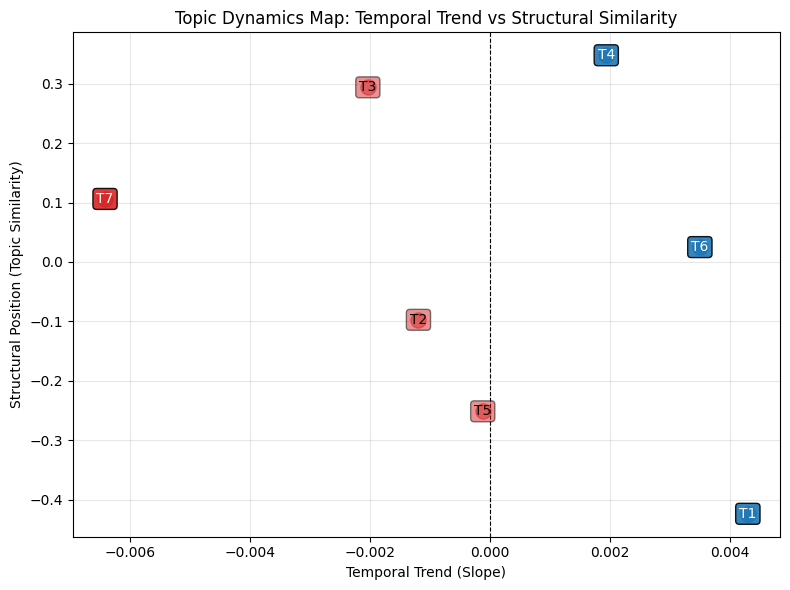

In [73]:

plt.figure(figsize=(8, 6))

for _, row in plot_df.iterrows():
    color = "#1f77b4" if row["slope"] > 0 else "#d62728"
    alpha = 0.9 if row["p_value"] < 0.05 else 0.5  # 유의한 토픽 강조

    plt.scatter(
        row["slope"],
        row["y_struct"],
        color=color,
        s=120,
        alpha=alpha
    )

    plt.text(
        row["slope"],
        row["y_struct"],
        row["topic"].replace("Topic ", "T"),
        fontsize=10,
        ha="center",
        va="center",
        color="white" if alpha > 0.7 else "black",
        bbox=dict(boxstyle="round,pad=0.25", fc=color, alpha=alpha)
    )

plt.axvline(0, color="black", linestyle="--", linewidth=0.8)

plt.xlabel("Temporal Trend (Slope)")
plt.ylabel("Structural Position (Topic Similarity)")
plt.title("Topic Dynamics Map: Temporal Trend vs Structural Similarity")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [74]:

import numpy as np

# =========================================================
# 1️⃣ 데이터 복사
# =========================================================
df_year = df.copy()

# =========================================================
# 2️⃣ 연도 컬럼 정리
# =========================================================
df_year["year"] = pd.to_numeric(df_year["Year"], errors="coerce")
df_year = df_year.dropna(subset=["year"])
df_year["year"] = df_year["year"].astype(int)

# =========================================================
# 3️⃣ 1974년 기준 5년 단위 구간 생성
# =========================================================
START_YEAR = 1971
BIN_SIZE = 5
END_YEAR = 2025

# ✅ 2025년까지만 필터링
df_year = df_year[df_year["year"] <= END_YEAR]

df_year["period_start"] = (
    START_YEAR + ((df_year["year"] - START_YEAR) // BIN_SIZE) * BIN_SIZE

)

df_year["period_label"] = (
    df_year["period_start"].astype(str)
    + "-"
    + (df_year["period_start"] + BIN_SIZE - 1).astype(str)
)

# =========================================================
# 4️⃣ 5년 단위 논문 수
# =========================================================
paper_counts_5y = (
    df_year
    .groupby("period_label")
    .size()
    .sort_index()
)

# =========================================================
# 5️⃣ 5년 단위 증감(Δ)
# =========================================================
paper_change_5y = paper_counts_5y.diff()

# =========================================================
# 6️⃣ 결과 출력
# =========================================================
paper_counts_5y, paper_change_5y


(period_label
 1971-1975      2
 1976-1980      4
 1981-1985     11
 1986-1990     14
 1991-1995     10
 1996-2000     22
 2001-2005     29
 2006-2010     69
 2011-2015    128
 2016-2020    176
 2021-2025    267
 dtype: int64,
 period_label
 1971-1975     NaN
 1976-1980     2.0
 1981-1985     7.0
 1986-1990     3.0
 1991-1995    -4.0
 1996-2000    12.0
 2001-2005     7.0
 2006-2010    40.0
 2011-2015    59.0
 2016-2020    48.0
 2021-2025    91.0
 dtype: float64)

In [75]:
# =========================================================
# 1️⃣ 5년 단위 집계 테이블 생성
# =========================================================
table_5y = paper_counts_5y.reset_index()
table_5y.columns = ["Period", "Paper_Count"]

# =========================================================
# 2️⃣ 전년비(이전 구간 대비 증감률, %) 계산
# =========================================================
table_5y["YoY_%"] = table_5y["Paper_Count"].pct_change() * 100

# =========================================================
# 3️⃣ 보기 좋게 반올림
# =========================================================
table_5y["YoY_%"] = table_5y["YoY_%"].round(2)

table_5y


,Period,Paper_Count,YoY_%
0,1971-1975,2,NaN
1,1976-1980,4,100.00
2,1981-1985,11,175.00
3,1986-1990,14,27.27
4,1991-1995,10,-28.57
5,1996-2000,22,120.00
6,2001-2005,29,31.82
7,2006-2010,69,137.93
8,2011-2015,128,85.51
9,2016-2020,176,37.50


In [76]:
table_5y.to_csv("paper_count_5year_yoy.csv", index=False, encoding="utf-8-sig")


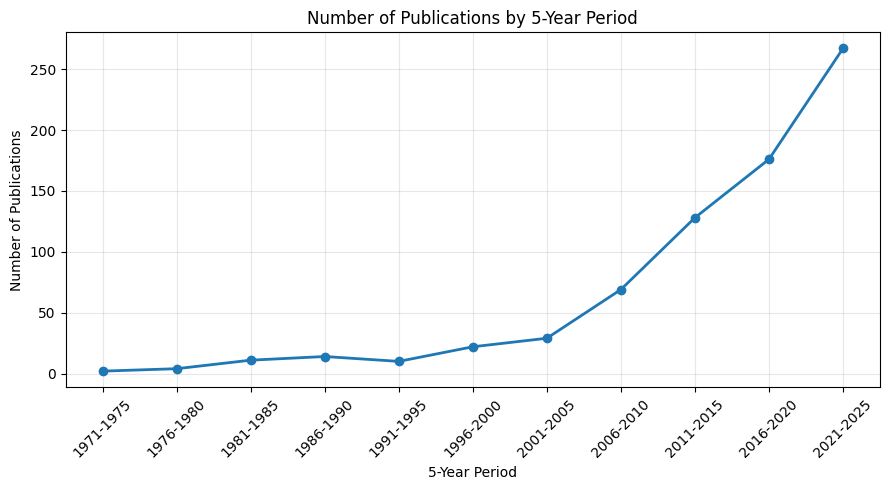

In [77]:
plt.figure(figsize=(9, 5))
plt.plot(paper_counts_5y.index, paper_counts_5y.values, marker="o", linewidth=2)
plt.title("Number of Publications by 5-Year Period")
plt.xlabel("5-Year Period")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [78]:

# 문서별 토픽 분포 행렬 생성 (문서 수 × 토픽 수)
doc_topic_dist = np.array([
    [prob for _, prob in lda_model.get_document_topics(doc, minimum_probability=0)]
    for doc in corpus
])



In [79]:
# 토픽별 평균 비중 계산
topic_share = doc_topic_dist.mean(axis=0)

# 데이터프레임으로 정리
df_topic_share = pd.DataFrame({
    "Topic": [f"Topic {i+1}" for i in range(len(topic_share))],
    "Proportion": topic_share
})

# 정렬 (선택)
df_topic_share = df_topic_share.sort_values("Proportion", ascending=False)

df_topic_share


,Topic,Proportion
0,Topic 1,0.209123
6,Topic 7,0.192827
5,Topic 6,0.147574
1,Topic 2,0.123556
2,Topic 3,0.114790
4,Topic 5,0.107645
3,Topic 4,0.104485


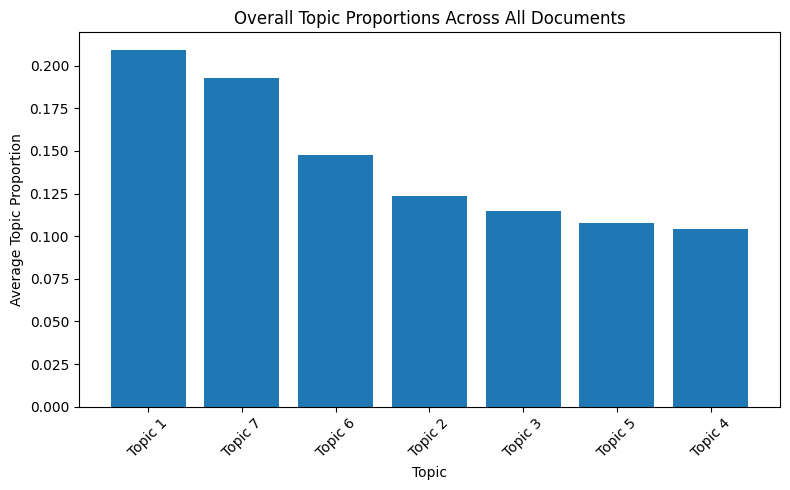

In [80]:
plt.figure(figsize=(8, 5))
plt.bar(df_topic_share["Topic"], df_topic_share["Proportion"])
plt.ylabel("Average Topic Proportion")
plt.xlabel("Topic")
plt.title("Overall Topic Proportions Across All Documents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


그림 X. 전체 문서에서 토픽별 평균 비중의 누적 분포
(각 문서의 토픽 확률을 평균하여 산출)

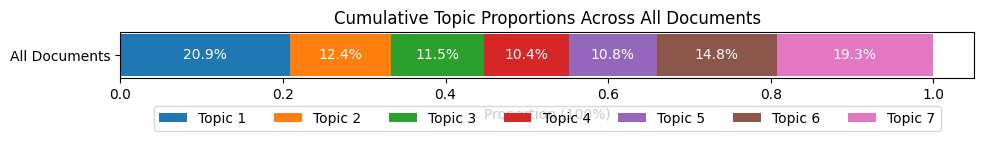

In [81]:


# =========================================================
# 1️⃣ 토픽 비중 계산
# =========================================================
topic_share = doc_topic_dist.mean(axis=0)

df_topic_share = pd.DataFrame({
    "Topic": [f"Topic {i+1}" for i in range(len(topic_share))],
    "Proportion": topic_share
})

# =========================================================
# 2️⃣ 누적 막대 + 퍼센티지 표시
# =========================================================
plt.figure(figsize=(10, 2))

left = 0
colors = plt.cm.tab10.colors

for i, row in df_topic_share.iterrows():
    width = row["Proportion"]
    percent = width * 100

    plt.barh(
        ["All Documents"],
        width,
        left=left,
        color=colors[i % len(colors)],
        label=row["Topic"]
    )

    # 퍼센티지 텍스트 (가운데 배치)
    plt.text(
        left + width / 2,
        0,
        f"{percent:.1f}%",
        va="center",
        ha="center",
        fontsize=10,
        color="white" if percent > 7 else "black"
    )

    left += width

plt.xlabel("Proportion (100%)")
plt.title("Cumulative Topic Proportions Across All Documents")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.45),
    ncol=len(df_topic_share)
)

plt.tight_layout()
plt.show()


In [82]:
category_map = {
    "Material- and Spatially Grounded Design Practices": ["Topic 1","Topic 5", "Topic 6"],
    "Sensory Social Interaction and Learning & Development": ["Topic 3", "Topic 7"],
    "Digital and Media-Based Interaction": ["Topic 2","Topic 4"]
}



In [83]:
category_colors = {
    "A. Material- and Spatially Grounded Design Practices" : "#1f77b4",  # 파랑
    "B. Sensory Social Interaction and Learning & Developmen": "#ff7f0e", # 주황
    "C. Digital and Media-Based Interaction": "#2ca02c"   # 초록
}


In [84]:


category_share = {}

is_series = isinstance(topic_share, (pd.Series, pd.DataFrame))

for cat, topic_idxs in category_map.items():
    # topic_idxs가 ['Topic 1', ...] 형태면 그대로, [1,6,5]면 변환
    if len(topic_idxs) == 0:
        category_share[cat] = 0
        continue

    first = topic_idxs[0]

    if is_series:
        # Series 인덱스가 'Topic 1' 형태라고 가정
        if isinstance(first, str):
            category_share[cat] = topic_share.loc[topic_idxs].sum()
        else:
            cols = [f"Topic {i}" for i in topic_idxs]
            category_share[cat] = topic_share.loc[cols].sum()
    else:
        # numpy 배열이면 정수 인덱스로만
        arr = np.asarray(topic_share)
        if isinstance(first, str):
            nums = [int(s.replace("Topic", "").strip()) for s in topic_idxs]
        else:
            nums = list(topic_idxs)
        idx0 = [n - 1 for n in nums]  # 0-based
        category_share[cat] = arr[idx0].sum()

df_category_share = pd.DataFrame({
    "Category": list(category_share.keys()),
    "Proportion": list(category_share.values())
})

df_category_share


,Category,Proportion
0,Material- and Spatially Grounded Design Practices,0.464342
1,Sensory Social Interaction and Learning & Deve...,0.307617
2,Digital and Media-Based Interaction,0.228041


In [109]:
print("합:", df_category_share["Proportion"].sum())


합: 1.0


In [110]:
df_category_share["Proportion"] = df_category_share["Proportion"] / df_category_share["Proportion"].sum()


In [111]:
print("cats:", cats)
print("len(cats):", len(cats))


cats: ['A. Material- and Spatially Grounded Design Practices', 'B. Sensory Social Interaction and Learning & Developmen', 'C. Digital and Media-Based Interaction']
len(cats): 3


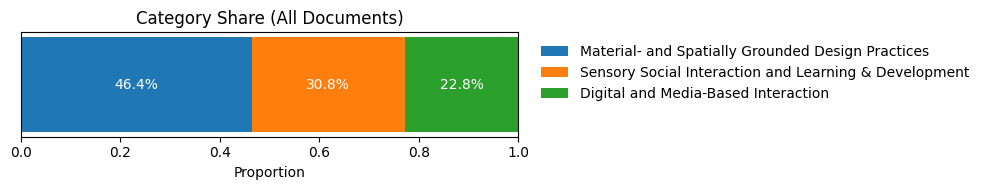

In [114]:
import re
import matplotlib.pyplot as plt

# =========================
# 0) 카테고리명 정규화 함수
#    - "A. " 같은 접두사 제거
# =========================
def normalize_cat(s):
    s = str(s).strip()
    return re.sub(r"^[A-Z]\.\s*", "", s)

# =========================
# 1) 색상 고정(파/주/초)
#    - 접두사 없는 이름 기준으로 통일
# =========================
category_colors = {
    "Material- and Spatially Grounded Design Practices": "tab:blue",
    "Sensory Social Interaction and Learning & Development": "tab:orange",
    "Digital and Media-Based Interaction": "tab:green",
}

# =========================
# 2) (선택) df_category_share에 표준 카테고리 컬럼 추가
# =========================
df_plot = df_category_share.copy()
df_plot["Category_std"] = df_plot["Category"].apply(normalize_cat)

# =========================
# 3) 누적 막대(가로) 그리기
# =========================
plt.figure(figsize=(10, 2))
left = 0.0

for _, row in df_plot.iterrows():
    cat_raw = row["Category"]          # 원래 라벨(범례용)
    cat_std = row["Category_std"]      # 색상 매칭용

    width = max(0.0, float(row["Proportion"]))

    plt.barh(
        ["All Documents"],
        width,
        left=left,
        color=category_colors.get(cat_std, "tab:gray"),  # 없는 키는 회색 처리
        label=cat_raw
    )

    percent = width * 100
    plt.text(
        left + width / 2,
        0,
        f"{percent:.1f}%",
        ha="center",
        va="center",
        fontsize=10,
        color="white" if percent > 8 else "black"
    )

    left += width

plt.xlim(0, 1)
plt.yticks([])
plt.xlabel("Proportion")
plt.title("Category Share (All Documents)")

# =========================
# 4) 범례 중복 제거
# =========================
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys(),
           bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

plt.tight_layout()
plt.show()


토픽별 문서 분류

In [118]:
print(doc_topic_df.columns.tolist()[:10])


['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7']


In [119]:
# 문서별 주 토픽(확률 최대 토픽)
dominant_topic = doc_topic_df.idxmax(axis=1)

# Topic 1이 주 토픽인 문서 인덱스/확률
docs_topic1 = doc_topic_df[dominant_topic == "Topic 1"].copy()

print("Topic 1 dominant docs:", len(docs_topic1))
docs_topic1.sort_values("Topic 1", ascending=False).head(10)


Topic 1 dominant docs: 171


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
135,0.997192,0.000439,0.000443,0.000392,0.000419,0.000498,0.000617
172,0.995943,0.000635,0.000640,0.000566,0.000606,0.000719,0.000891
155,0.995856,0.000648,0.000653,0.000578,0.000619,0.000734,0.000911
43,0.995811,0.000656,0.000661,0.000584,0.000626,0.000742,0.000921
344,0.995619,0.000686,0.000691,0.000611,0.000654,0.000776,0.000963
211,0.995569,0.000693,0.000699,0.000618,0.000662,0.000785,0.000974
149,0.995516,0.000702,0.000707,0.000625,0.000670,0.000795,0.000985
496,0.995354,0.000727,0.000733,0.000648,0.000694,0.000823,0.001021
106,0.995178,0.000755,0.000760,0.000672,0.000720,0.000855,0.001060
52,0.995054,0.000774,0.000780,0.000690,0.000739,0.000877,0.001087


In [115]:
# 문서별 주 토픽 계산
dominant_topic = doc_topic_df.idxmax(axis=1)

# Topic 1이 주 토픽인 문서 인덱스
docs_topic1 = doc_topic_df[dominant_topic == "Topic 1"]

print(len(docs_topic1))
docs_topic1.head()


171


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
2,0.755371,0.000494,0.061512,0.000440,0.000471,0.181019,0.000693
8,0.399906,0.000494,0.272366,0.000440,0.000471,0.000559,0.325763
25,0.665832,0.330634,0.000661,0.000584,0.000626,0.000743,0.000921
26,0.589046,0.000678,0.000683,0.077840,0.330034,0.000768,0.000952
31,0.561281,0.000702,0.039935,0.000625,0.000670,0.395803,0.000985


In [120]:
docs_topic1_thr = doc_topic_df[doc_topic_df["Topic 1"] >= 0.30].copy()

print("Topic 1 >= 0.30 docs:", len(docs_topic1_thr))
docs_topic1_thr.sort_values("Topic 1", ascending=False).head(10)


Topic 1 >= 0.30 docs: 216


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7
135,0.997192,0.000439,0.000443,0.000392,0.000419,0.000498,0.000617
172,0.995943,0.000635,0.000640,0.000566,0.000606,0.000719,0.000891
155,0.995856,0.000648,0.000653,0.000578,0.000619,0.000734,0.000911
43,0.995811,0.000656,0.000661,0.000584,0.000626,0.000742,0.000921
344,0.995619,0.000686,0.000691,0.000611,0.000654,0.000776,0.000963
211,0.995569,0.000693,0.000699,0.000618,0.000662,0.000785,0.000974
149,0.995516,0.000702,0.000707,0.000625,0.000670,0.000795,0.000985
496,0.995354,0.000727,0.000733,0.000648,0.000694,0.000823,0.001021
106,0.995178,0.000755,0.000760,0.000672,0.000720,0.000855,0.001060
52,0.995054,0.000774,0.000780,0.000690,0.000739,0.000877,0.001087


In [121]:
cols_to_show = [c for c in ["Title", "Abstract", "Year"] if c in df.columns]

topic1_docs_view = (
    df.loc[docs_topic1.index, cols_to_show]
      .assign(topic1_weight=doc_topic_df.loc[docs_topic1.index, "Topic 1"])
      .sort_values("topic1_weight", ascending=False)
)

topic1_docs_view.head(10)


,Title,Abstract,Year,topic1_weight
135,Pioneering a Theological Curriculum for Our Ti...,“Decolonizing the mind” (Ngugi) is an ongoing ...,2023,0.997192
172,Baan Fai Rim Ping: a haptic approach to the ph...,Standing on the west bank of the Ping river in...,2023,0.995943
155,Director training and education: models from B...,This paper presents a conversation that took p...,2023,0.995856
43,Language learning playware: a ‘playful learnin...,This article opens a window on ‘playful learni...,2025,0.995811
344,Re-Channeling Language: The Mutual Restructuri...,This article is concerned with the re-channeli...,2018,0.995619
211,An ecological approach to mapping remote creat...,There is increasing recognition that the creat...,2022,0.995569
149,Etnodizajn and Folkstar Souvenirs: Polish Expe...,The present paper offers a critical reflection...,2023,0.995516
496,Channels of vision and the poetics of drawing:...,This article introduces a novel approach to pe...,2014,0.995354
106,THE PRESENCE OF CRITICAL REGIONALISM IN CONTEM...,"In the last few decades, contemporary mosque a...",2024,0.995178
52,Who Can You Trust? Integrating Ethical Dilemma...,"In an ideal world, graphic designers can pick ...",2025,0.995054


In [122]:
topic1_docs_view.to_excel("Topic1_documents.xlsx", index=False)


In [123]:


# 토픽 컬럼(1~7)만 자동 선택: 'Topic 1'..'Topic 7' 형태라고 가정
topic_cols = [c for c in doc_topic_df.columns if str(c).startswith("Topic")]

out = doc_topic_df[topic_cols].copy()
out["dominant_topic"] = out[topic_cols].idxmax(axis=1)
out["dominant_weight"] = out[topic_cols].max(axis=1)

# df에서 같이 붙이고 싶은 메타데이터(있는 것만 자동 추가)
meta_cols = [c for c in ["Title", "Abstract", "Year"] if c in df.columns]
if meta_cols:
    out = df.loc[out.index, meta_cols].join(out)

out.to_excel("doc_topics_all.xlsx", index=True)
print("Saved:", "doc_topics_all.xlsx")


Saved: doc_topics_all.xlsx
